In [1]:
from TdCARS import TdCARS
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

c:\Users\dinus\OneDrive\Documents\Projects\Python\Python Physics\Optics\td_CARS_fit\TdCARS.py:250: SyntaxWarning: invalid escape sequence '\,'
  plt.xlabel("$wavenumber$ [1/cm]"); plt.ylabel("$t_d\, [fs]$"); plt.grid(); plt.show()
c:\Users\dinus\OneDrive\Documents\Projects\Python\Python Physics\Optics\td_CARS_fit\TdCARS.py:336: SyntaxWarning: invalid escape sequence '\,'
  plt.title(f"$CARS\,\, signal\,\,vs\,\, dellay\,\, @\,\, wavenumber\,\, =\,\, {self.wn_as[self.wn_as>=wn_target][-1]:.0f}\,$"+r"$cm^{-1}$"+"$\, for\,\, {self.sample}$")
c:\Users\dinus\OneDrive\Documents\Projects\Python\Python Physics\Optics\td_CARS_fit\TdCARS.py:336: SyntaxWarning: invalid escape sequence '\,'
  plt.title(f"$CARS\,\, signal\,\,vs\,\, dellay\,\, @\,\, wavenumber\,\, =\,\, {self.wn_as[self.wn_as>=wn_target][-1]:.0f}\,$"+r"$cm^{-1}$"+"$\, for\,\, {self.sample}$")
c:\Users\dinus\OneDrive\Documents\Projects\Python\Python Physics\Optics\td_CARS_fit\TdCARS.py:336: SyntaxWarning: invalid escape sequence '\,'


In [2]:
def gaussian(x, A, x0, gamma, B):
    return A * np.exp(-((x - x0) / gamma) ** 2) + B

def linear(x, m, b):
    return m * x + b

def sin_fit(x, A, omega, phi):
    return A * np.sin(x * omega + phi)

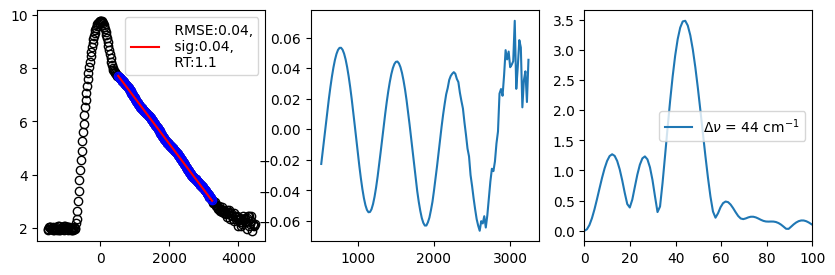

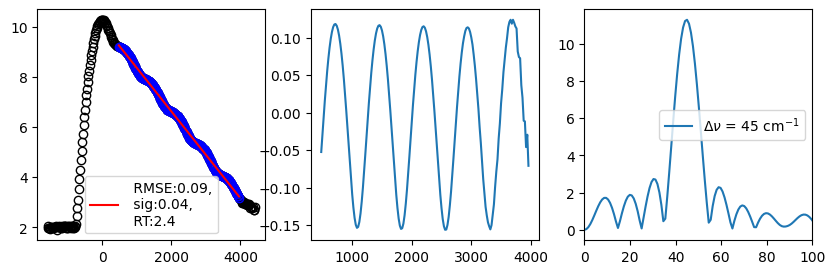

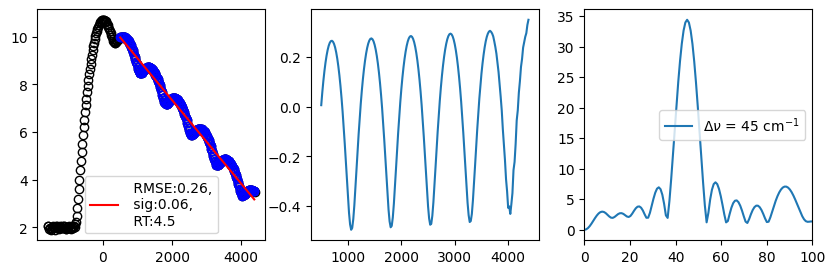

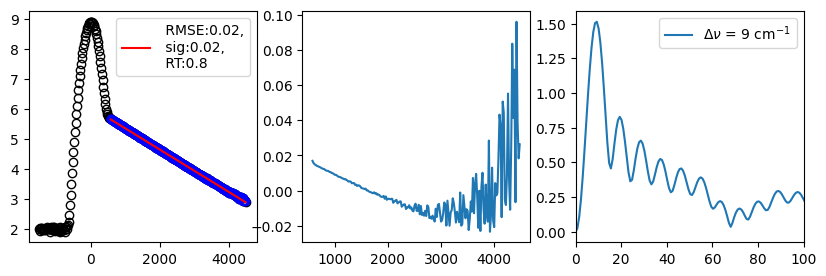

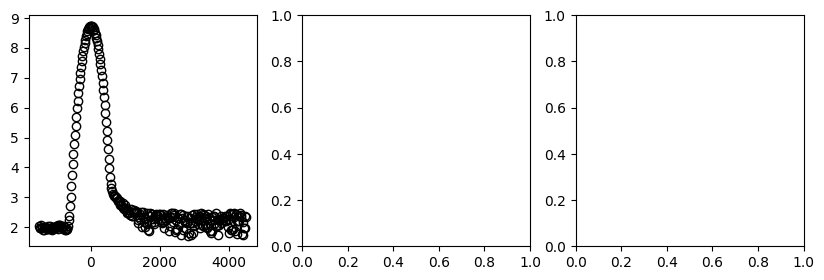

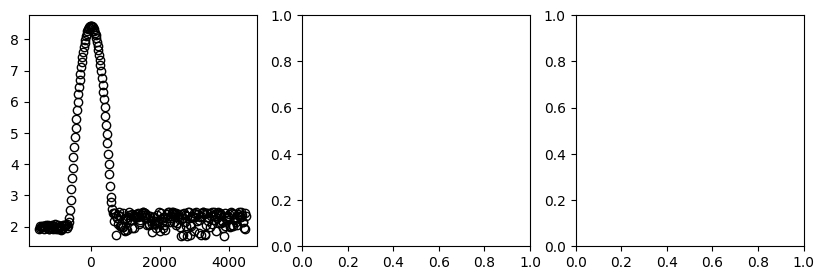

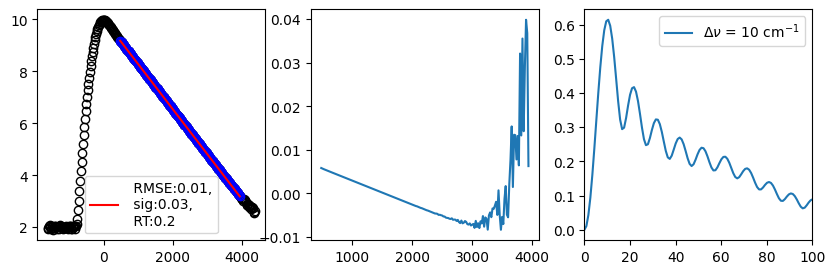

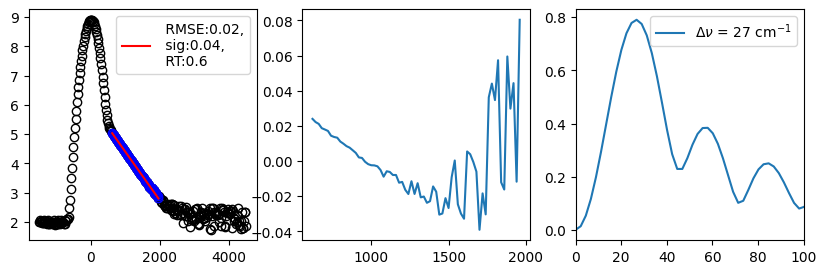

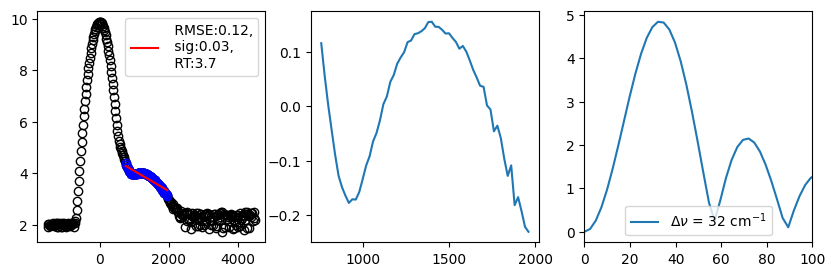

In [3]:
for i in range(9):
    data = np.loadtxt(f'tdCARS_mock_data/transient_data_{i}.dat',skiprows=1, dtype=float, delimiter='\t')
    signal_exp_log = np.log10(data[:,1])
    index_at_sig_max = np.argmax(signal_exp_log)
    td_exp = data[:,0]
    td_exp = td_exp - td_exp[index_at_sig_max]
    x = td_exp[td_exp < td_exp[index_at_sig_max]]
    y = signal_exp_log[td_exp < td_exp[index_at_sig_max]]
    x = np.concatenate([x, np.abs(np.flip(x))])
    y = np.concatenate([y, np.flip(y)])

    popt3, pcov3 = curve_fit(gaussian, x, y, p0=[np.max(y),0,500,np.min(y)])
    
    xx = td_exp
    yy = gaussian(xx, *popt3)
    dyy = signal_exp_log-yy
    std_dev_before_zero = np.std(dyy[xx < 0])
    mean_before_zero = np.mean(dyy[xx < 0])

    std_mul = 3
    td_rng = xx[(xx>0) & (dyy > mean_before_zero + std_mul * std_dev_before_zero)]
    td1, td2 = 0, 0
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.plot(td_exp, signal_exp_log, 'ko', mfc = 'none')
    if len(td_rng)!=0:
        td1, td2 = np.min(td_rng)+100, np.max(td_rng)
        x_td,y_td = td_exp[(td_exp>td1) & (td_exp<td2)], signal_exp_log[(td_exp>td1) & (td_exp<td2)]
        popt, pcov = curve_fit(linear, x_td, y_td, p0 = [1,1])
        y_td_fit = linear(x_td, *popt)
        rmse = np.sqrt(np.mean((y_td-y_td_fit)**2))
        sig_y = np.sqrt(np.mean(np.diff(y_td)**2))
        rt = rmse/sig_y #If rt>1 it is NOT LINEAR
        plt.plot(x_td,y_td, 'bo', mfc = 'none')
        plt.plot(x_td, y_td_fit,'r-', label=f' RMSE:{rmse:.2f},\n sig:{sig_y:.2f},\n RT:{rt:.1f}')
        plt.legend()
        if rt<1:
            pass   
        else:
            #plt.plot(x_td, y_td-y_td_fit, 'ko', mfc = 'none')
            pass
        x, y = x_td, y_td-y_td_fit
        plt.subplot(132)
        plt.plot(x,y)
        y_padded = np.pad(y, (0, 10*len(y)), 'constant')
        n = len(y_padded)
        y_fft = np.fft.fft(y_padded)
        y_fft_shifted = np.fft.fftshift(y_fft)
        freq = np.fft.fftfreq(n, d=(x[1]-x[0]))
        freq_shifted = np.fft.fftshift(freq)
        magnitude = np.abs(y_fft_shifted)
        delNu = np.abs(freq_shifted[magnitude==np.max(magnitude)][0]*1e15/3e10)
        lbl = r'$\Delta\nu$ = '+f'{delNu:.0f} '+r'cm$^{-1}$'
        plt.subplot(133)
        plt.plot(freq_shifted*1e15/3e10, magnitude, label = lbl)
        plt.xlim(0, 100)
        plt.legend()
        #print(f'Time range: {td1} fs to {td2} fs')
        #plt.plot(td_exp[(td_exp>td1) & (td_exp<td2)], signal_exp_log[(td_exp>td1) & (td_exp<td2)], 'ro', mfc = 'none')
    else:
        plt.subplot(132)
        plt.subplot(133)

In [4]:
def test_tdCARS_simulation_FG(i):
    data = np.loadtxt(f'tdCARS_mock_data/transient_data_{i}.dat',skiprows=1, dtype=float, delimiter='\t')

    floor = 100
    nuR = np.array([800,845])
    T2 = np.array([500,500])
    A = np.array([3.5e25, 3.5e25])
    
    tdCARS = TdCARS.from_params(1000, 1100, 260, 260, 200, -3000, 6000, floor, nuR, T2, A, 0)
    td_FG, signal_FG = tdCARS.CARS_simulation_FG()
    
    td_FG_short = td_FG[(td_FG >= np.min(data[:,0])) & (td_FG <= np.max(data[:,0]))]
    signal_FG = signal_FG[(td_FG >= np.min(data[:,0])) & (td_FG <= np.max(data[:,0]))]

    # Interpolate simulated data to match experimental time points
    simulated_signal_interp = np.interp(data[:,0], td_FG_short, np.log(signal_FG))

    # Perform linear regression between experimental and simulated signals
    slope, intercept, r_value, p_value, std_err = linregress(np.log(data[:,1]), simulated_signal_interp)

    # Assert that the correlation coefficient is above a certain threshold
    #assert r_value**2 > 0.95, f"Low correlation: R^2 = {r_value**2}"
    return np.round(r_value**2,4), (r_value**2)>0.9990

In [5]:
for i in range(8):
    print(test_tdCARS_simulation_FG(i))

(np.float64(0.9496), np.False_)
(np.float64(0.9998), np.True_)
(np.float64(0.9864), np.False_)
(np.float64(0.875), np.False_)
(np.float64(0.4367), np.False_)
(np.float64(0.3798), np.False_)
(np.float64(0.9945), np.False_)
(np.float64(0.6775), np.False_)


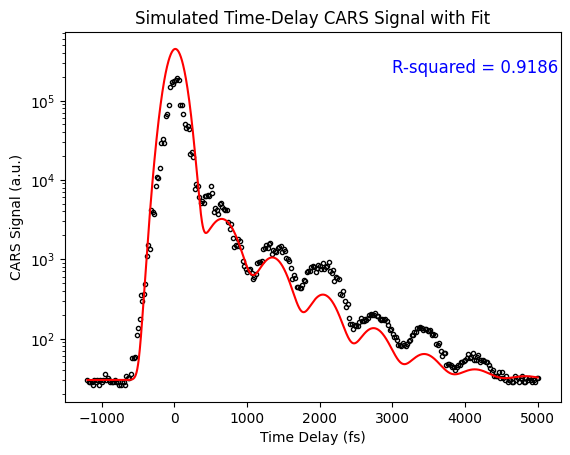

In [45]:
data = np.loadtxt('KTP_CARS_3.dat', dtype=float, delimiter='\t')
wl1, wl2 = 1000, 1105
nuR = 1e7*(1/wl1-1/wl2)
dnuR = 48
off_nuR = -130
A = 1e23
phi = 0
tdCARS = TdCARS.from_params(wl1, wl2, 260, 260, 200, -3000, 6000, 30, np.array([nuR-dnuR/2+off_nuR,nuR+dnuR/2+off_nuR]), np.array([1300,1200]), np.array([A*5,A]), phi)
td_FG, signal_FG = tdCARS.CARS_simulation_FG()
td_FG_short = td_FG[(td_FG >= np.min(data[:,0])) & (td_FG <= np.max(data[:,0]))]
signal_FG = signal_FG[(td_FG >= np.min(data[:,0])) & (td_FG <= np.max(data[:,0]))]
td_FG_low_res, signal_FG_low_res = td_FG_short[::4], signal_FG[::4] 

only_after_zero = True
x_exp, y_exp = data[:,0], np.log(data[:,1])
x_fit, y_fit = td_FG_low_res, np.log(signal_FG_low_res)
if only_after_zero:
    mask_exp = x_exp >= 0
    x_exp, y_exp = x_exp[mask_exp], y_exp[mask_exp]
    mask_fit = x_fit >= 0
    x_fit, y_fit = x_fit[mask_fit], y_fit[mask_fit]
#calculate R-squared
ss_res = np.sum((y_exp - np.interp(x_exp, x_fit, y_fit))**2)
ss_tot = np.sum((y_exp - np.mean(y_exp))**2)
r_squared = 1 - (ss_res / ss_tot)

plt.semilogy(data[:,0], data[:,1], 'k.', mfc='none')
plt.semilogy(td_FG_short, signal_FG, 'r-')
plt.text(0.6*max(td_FG_short), 0.5*max(signal_FG), f'R-squared = {r_squared:.4f}', fontsize=12, color='blue')
plt.xlabel('Time Delay (fs)')
plt.ylabel('CARS Signal (a.u.)')
plt.title('Simulated Time-Delay CARS Signal with Fit')
plt.show()

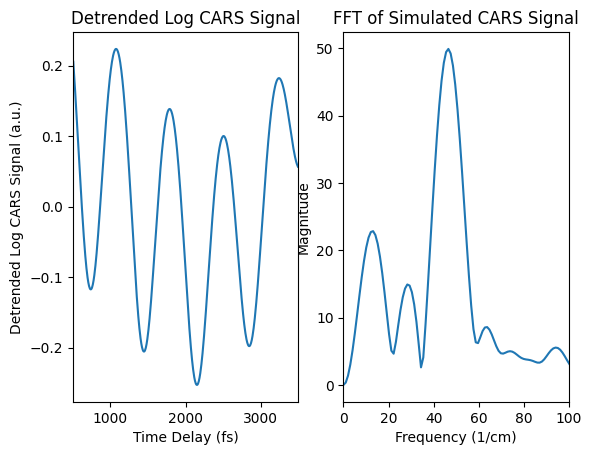

In [7]:
#fft analysis
td1,td2 = 500,3500
x = td_FG_short[(td_FG_short > td1) & (td_FG_short < td2)]
y = np.log(signal_FG[(td_FG_short > td1) & (td_FG_short < td2)])

slope, intercept, r_value, p_value, std_err = linregress(x, y)
y = y-(slope*x+intercept)
y_padded = np.pad(y, (0, 10*len(y)), 'constant')

n = len(y_padded)
y_fft = np.fft.fft(y_padded)
y_fft_shifted = np.fft.fftshift(y_fft)
freq = np.fft.fftfreq(n, d=(x[1]-x[0]))
freq_shifted = np.fft.fftshift(freq)
magnitude = np.abs(y_fft_shifted)

plt.subplot(122)
plt.plot(freq_shifted*1e15/3e10, magnitude)
plt.xlim(0, 100)
plt.xlabel('Frequency (1/cm)')
plt.ylabel('Magnitude')
plt.title('FFT of Simulated CARS Signal')
plt.subplot(121)
plt.plot(x, y)
plt.xlim(td1, td2)
plt.xlabel('Time Delay (fs)')
plt.ylabel('Detrended Log CARS Signal (a.u.)')
plt.title('Detrended Log CARS Signal')
plt.show()

In [8]:
%run u_test.py

..F
FAIL: test_add_positive_numbers (__main__.TestAddFunction.test_add_positive_numbers)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\dinus\OneDrive\Documents\Projects\Python\Python Physics\Optics\td_CARS_fit\u_test.py", line 8, in test_add_positive_numbers
    self.assertEqual(add(1, 2), 4)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
AssertionError: 3 != 4

----------------------------------------------------------------------
Ran 3 tests in 0.004s

FAILED (failures=1)


SystemExit: 1